In [1]:
import cv2
import numpy as np

In [5]:
def timeVideo(in_add, out_add):
    
    cap = cv2.VideoCapture(in_add)
    ret, frame = cap.read()
    count = 1
    
    while(cap.isOpened()):
        if ret:
            cv2.imwrite(out_add + "/frame{}.png".format(count), frame)
            count += 1

        else:
            break
        ret, frame = cap.read()

    cap.release()
    cv2.destroyAllWindows()
    print(count)

In [6]:
timeVideo("./data/test.mp4", "./data/frames_test")

10799


In [1]:
from dataloader import *
from torchvision import transforms
from torchvision.models import *
import matplotlib.pyplot as plt

In [2]:
class Resnet50(object):

    def __init__(self):
        self.resnet50 = wide_resnet50_2(pretrained=True).eval()
        self.resnet50 = self.resnet50.to("cuda:0")
    def __call__(self, sample):
        sample = sample.to("cuda:0")
        with torch.no_grad():
            out = self.resnet50(sample.unsqueeze(0))
            return out.squeeze()

In [3]:
preprocess_in = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((240, 240)),
    #Resnet50()
])

In [4]:
tr_loader = winterdata("../signals/data/frames", preprocess_in)


In [14]:
tr_loader = winterdata("../signals/data/frames", preprocess_in)
#tra, val = random_split(tr_loader, [int(len(tr_loader) * 0.8), int(len(tr_loader) * 0.2)])
tra = torch.utils.data.Subset(tr_loader, (range(0, int(len(tr_loader) * 0.8))))
val = torch.utils.data.Subset(tr_loader, (range(int(len(tr_loader) * 0.8), len(tr_loader))))


train_loader = DataLoader(dataset = tra, batch_size = 32, shuffle = False)
val_loader = DataLoader(dataset = val, batch_size = 32, shuffle = False)

0
23
1
23
2
23
3
23
4
23
5
23
6
23
7
23
8
23
9
23
10
23
11
23
12
23
13
23
14
23
15
23
16
23
17
23
18
23
19
23
20
23
21
23
22
23
23
23
24
23
25
23
26
23
27
23
28
23
29
23
30
23
31
23
tensor(-0.0100, dtype=torch.float64)


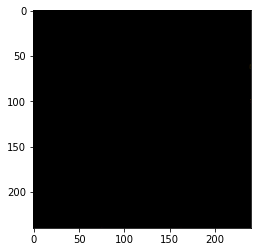

In [15]:
for i in train_loader:
    print(i['label'][0])
    plt.imshow(i['image'][0].permute(1, 2, 0))
    plt.show()
    break